# <center>Traitement des données distribuées</center>

**<center>LACOSTE Rémi & LY Yannick</center>**

Dans ce projet dédié à Spark, nous avons choisi de reprendre un projet de Machine Learning soumis au premier semestre lors du cours "Machine Learning". Nous nous sommes fixés pour objectif de le convertir en utilisant les fonctionnalités offertes par Spark.

Nous ne referons donc pas l'analyse de l'aspect Machine Learning puisque celle-ci a déjà été réalisée précédemment. L'idée est de montrer qu'on est capable de faire la traduction de chacun des éléments.

Etant donné que le cluster de l'ENSAE affiche une "DataError" et que nos machines locales ne sont pas assez puissantes, nous avons décider de travailler sur un sous-échantillon du dataset (5%). De plus afin de pouvoir faire tourner la partie gridsearch et cross-validation, il a fallu augmenter la mémoire allouée localement à spark en modifiant 'spark.driver.memory' à 12g. Pour se faire, cela passe par la création/modification du fichier 'spark-defaults.conf' présent dans le dossier 'conf' de spark.

## Vérification du fonctionnement de Spark et importation des librairies

In [2]:
import pyspark
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, VectorIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from pyspark.sql.functions import col, isnan, when, count, col, abs, mean

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [3]:
spark

In [4]:
spark.sparkContext._conf.getAll()

[('spark.app.id', 'local-1589904125221'),
 ('spark.driver.memory', '12g'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '10.217.0.18'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.driver.port', '58230')]

## Importation des données

In [5]:
%%time

data = spark.read.csv("data.csv", header=True, inferSchema=True) 
# inferSchema=True demande à spark de deviner le type des éléments d'une colonne
# Si inferSchema=False, les éléments sont stockés en tant que string

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.31 s


In [6]:
%%time

data_matchId = data.select("matchId").drop_duplicates().sample(False, 0.05, seed = 955) # 5% du data set

splits = data_matchId.randomSplit([0.6, 0.4], seed = 955)
tr_matchId = [r[0] for r in splits[0].collect()] # matchId du training set
te_matchId = [r[0] for r in splits[1].collect()] # matchId du validation set

tr_df = data.where(col("matchId").isin(tr_matchId)) # data du training set
te_df = data.where(col("matchId").isin(te_matchId)) # data du testing set

CPU times: user 281 ms, sys: 266 ms, total: 547 ms
Wall time: 15.6 s


In [5]:
print("Type de la variable tr_matchId :", type(tr_df))
print("Nombre de matchs - training set :", len(tr_matchId))
print("Nombre de couples joueur/match - training set :", tr_df.count())
print("-----------------------------------------------------------------")
print("Nombre de matchs - testing set :", len(te_matchId))
print("Nombre de couples joueur/match - testing set :", te_df.count())

Type de la variable tr_matchId : <class 'pyspark.sql.dataframe.DataFrame'>
Nombre de matchs - training set : 1484
Nombre de couples joueur/match - training set : 138063
-----------------------------------------------------------------
Nombre de matchs - testing set : 979
Nombre de couples joueur/match - testing set : 90496


## Exploration

### Structure des données

In [6]:
# Type de chaque colonne
tr_df.printSchema() 

root
 |-- Id: string (nullable = true)
 |-- groupId: string (nullable = true)
 |-- matchId: string (nullable = true)
 |-- assists: integer (nullable = true)
 |-- boosts: integer (nullable = true)
 |-- damageDealt: double (nullable = true)
 |-- DBNOs: integer (nullable = true)
 |-- headshotKills: integer (nullable = true)
 |-- heals: integer (nullable = true)
 |-- killPlace: integer (nullable = true)
 |-- killPoints: integer (nullable = true)
 |-- kills: integer (nullable = true)
 |-- killStreaks: integer (nullable = true)
 |-- longestKill: double (nullable = true)
 |-- matchDuration: integer (nullable = true)
 |-- matchType: string (nullable = true)
 |-- maxPlace: integer (nullable = true)
 |-- numGroups: integer (nullable = true)
 |-- rankPoints: integer (nullable = true)
 |-- revives: integer (nullable = true)
 |-- rideDistance: double (nullable = true)
 |-- roadKills: integer (nullable = true)
 |-- swimDistance: double (nullable = true)
 |-- teamKills: integer (nullable = true)
 |--

In [7]:
tr_df.toPandas()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,bc6194d5fa2fe5,f7588bdd7bd695,4e7d32f7b41b45,0,1,529.30,3,0,0,12,...,0,0.0,0,0.00,0,0,534.10,4,1490,0.3958
1,9d0db0d43f0358,74e4d4d327a5f1,d7533af8a58b44,0,3,269.70,3,0,5,6,...,2,0.0,0,0.00,0,0,1575.00,7,0,0.9643
2,2d961430e682a0,6bc402dbaa6810,07c6e81561dc98,0,2,43.00,0,0,0,61,...,0,0.0,0,0.00,0,0,92.30,1,1496,0.4583
3,966dbb6ea37f70,6a07ff16cf8751,7d27c4c4aa7083,0,0,0.00,0,0,0,65,...,0,0.0,0,0.00,0,0,133.90,2,1502,0.2727
4,2e3fe1baed3418,40025fde839ad0,ed73cc4ae11c87,0,0,29.40,0,0,0,80,...,0,0.0,0,0.00,0,0,82.96,1,1584,0.2963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138058,fcf176e60f7029,d52ada6102536e,4536c85a1e5b00,1,7,336.00,1,0,5,11,...,1,7989.0,0,0.00,0,0,2491.00,11,0,0.9792
138059,516dc22868ca74,6800014afe7373,ba5fec3966e875,0,2,31.85,0,0,2,43,...,0,3599.0,0,0.00,0,0,4417.00,7,0,0.7872
138060,00230824dd1763,9605dc0406efc9,077d9bc6ebffe1,0,0,86.00,0,0,0,86,...,0,0.0,0,0.00,0,0,95.14,1,1408,0.1250
138061,ab2138a2636da6,d953ca7febc96d,e8f187f8e42816,0,2,121.60,1,1,1,23,...,0,411.0,0,41.36,0,0,4245.00,4,0,0.8889


In [8]:
# Statistiques sur chaque colonne
for i in tr_df.columns:
    tr_df.describe(i).show()

+-------+--------------+
|summary|            Id|
+-------+--------------+
|  count|        138063|
|   mean|      Infinity|
| stddev|           NaN|
|    min|000056883d8510|
|    max|fffeeef8fdeea1|
+-------+--------------+

+-------+--------------+
|summary|       groupId|
+-------+--------------+
|  count|        138063|
|   mean|      Infinity|
| stddev|           NaN|
|    min|0000909041d5c1|
|    max|fffff305a0133d|
+-------+--------------+

+-------+-----------------+
|summary|          matchId|
+-------+-----------------+
|  count|           138063|
|   mean|2.217036220289E12|
| stddev|              0.0|
|    min|   00077604e50a63|
|    max|   ffe2a50b7023fb|
+-------+-----------------+

+-------+-------------------+
|summary|            assists|
+-------+-------------------+
|  count|             138063|
|   mean|0.23611684520834691|
| stddev| 0.6014077814380182|
|    min|                  0|
|    max|                 14|
+-------+-------------------+

+-------+---------------

### Univarié

#### Utilisation de MapReduce (RDD)

In [9]:
%%time

matchType = tr_df.select('matchType').rdd.map(lambda x: (x, 1)).reduceByKey(lambda c1, c2: c1 + c2)
print(type(matchType))
matchType.collect()

<class 'pyspark.rdd.PipelinedRDD'>
CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 2.38 s


[(Row(matchType='flaretpp'), 85),
 (Row(matchType='duo-fpp'), 31868),
 (Row(matchType='duo'), 9957),
 (Row(matchType='normal-solo-fpp'), 50),
 (Row(matchType='normal-squad'), 47),
 (Row(matchType='normal-squad-fpp'), 396),
 (Row(matchType='squad-fpp'), 53207),
 (Row(matchType='normal-duo-fpp'), 138),
 (Row(matchType='solo-fpp'), 16685),
 (Row(matchType='squad'), 21011),
 (Row(matchType='solo'), 4427),
 (Row(matchType='flarefpp'), 96),
 (Row(matchType='crashfpp'), 96)]

In [10]:
matchType.getNumPartitions()

12

#### Utilisation de PySpark.sql

In [11]:
%%time

matchType = tr_df.select('matchType').groupby('matchType').agg(F.count('matchType')).sort(F.desc('count(matchType)'))
matchType.show()
print(type(matchType))

+----------------+----------------+
|       matchType|count(matchType)|
+----------------+----------------+
|       squad-fpp|           53207|
|         duo-fpp|           31868|
|           squad|           21011|
|        solo-fpp|           16685|
|             duo|            9957|
|            solo|            4427|
|normal-squad-fpp|             396|
|  normal-duo-fpp|             138|
|        flarefpp|              96|
|        crashfpp|              96|
|        flaretpp|              85|
| normal-solo-fpp|              50|
|    normal-squad|              47|
+----------------+----------------+

<class 'pyspark.sql.dataframe.DataFrame'>
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.9 s


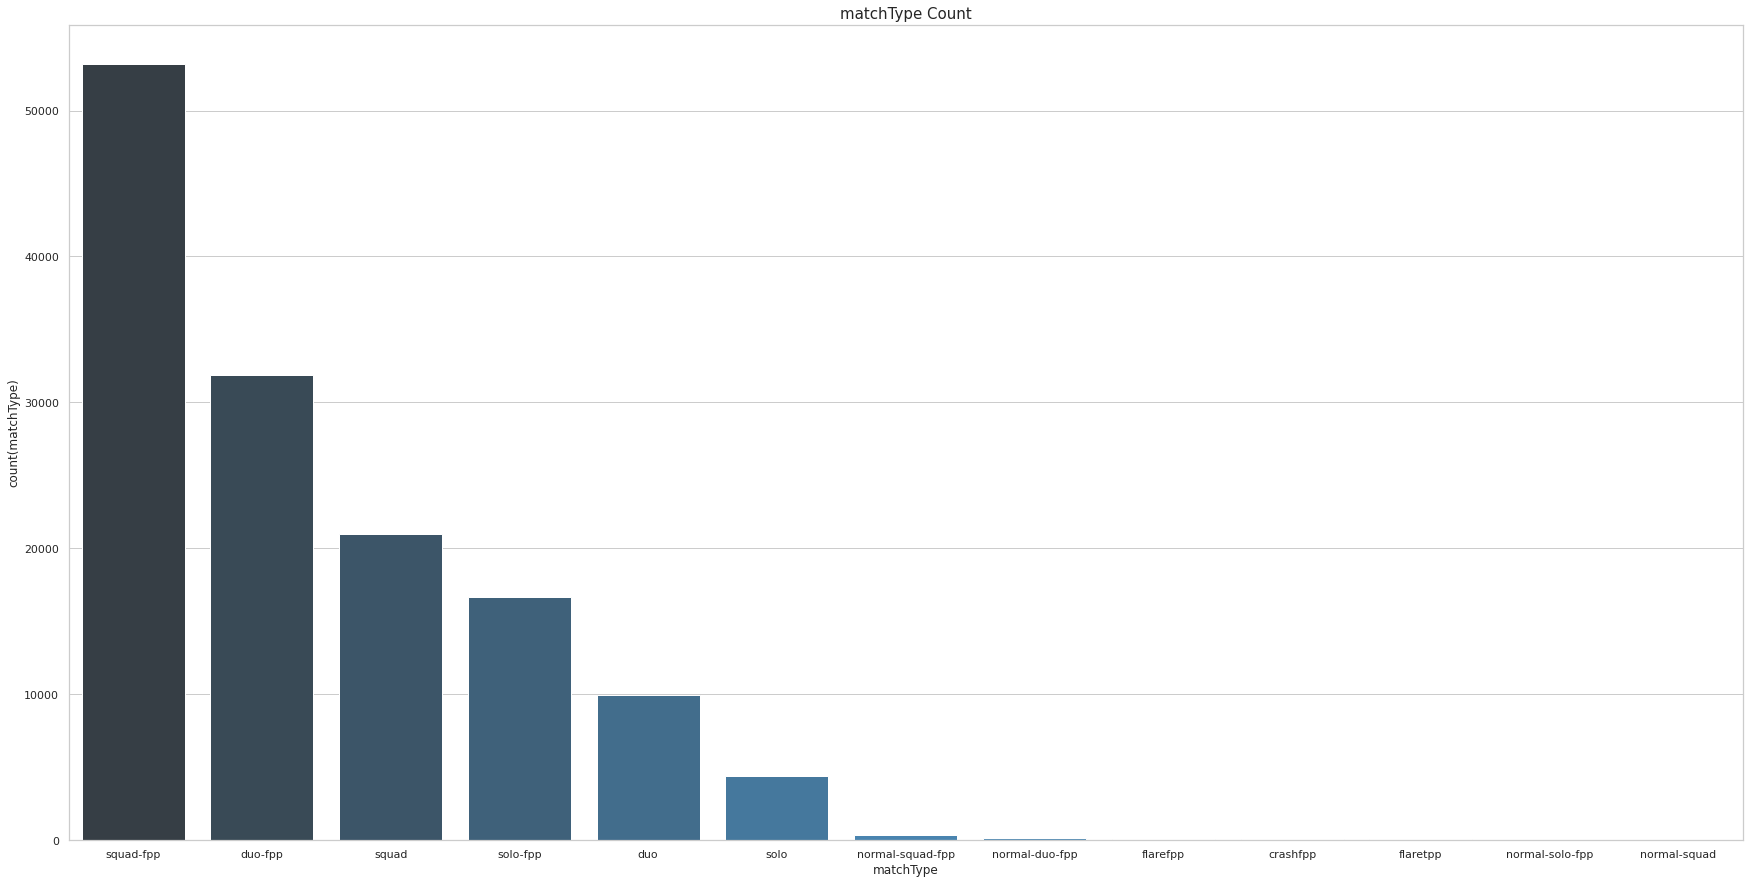

In [12]:
plt.figure(figsize = (30,15))
sns.set(style = "whitegrid")
ax = sns.barplot(x = "matchType", y = "count(matchType)", palette = "Blues_d", data = matchType.toPandas().sort_values(by=['count(matchType)'],ascending=False))
plt.title("matchType Count", fontsize = 15)
plt.show()

## Feature engineering

### Valeurs manquantes

In [13]:
tr_df.select([count(when(isnan(c), c)).alias(c) for c in tr_df.columns]).toPandas()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Remplacement de valeurs

In [14]:
# On ne garde que les matchs de type 'solo', 'duo' et 'squad'
df = tr_df.na.replace(['solo-fpp','normal-solo','normal-solo-fpp',
                                'duo-fpp','normal-duo','normal-duo-fpp',
                               'squad-fpp','normal-squad','normal-squad-fpp'],
                               ['solo', 'solo', 'solo',
                               'duo','duo','duo',
                               'squad','squad','squad'])
df.select("matchType").toPandas()

,matchType
0,duo
1,squad
2,duo
3,squad
4,squad
...,...
138058,duo
138059,duo
138060,duo
138061,squad


### Suppression de valeurs

In [15]:
df = df.where(~df.matchType.isin('flarefpp','flaretpp','crashfpp','crashtpp'))
df.count()

137786

### One Hot Encoding

In [16]:
# Transformation de la colonne string 'matchType' en numérique 
stringIndexer = StringIndexer(inputCol = 'matchType', outputCol = 'matchType_index')
model = stringIndexer.fit(df)
df = model.transform(df)

# One Hot Encoding
encoder = OneHotEncoder(inputCol = stringIndexer.getOutputCol(), outputCol = 'matchType_encoded')
df = encoder.transform(df)

df.toPandas()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,matchType_index,matchType_encoded
0,bc6194d5fa2fe5,f7588bdd7bd695,4e7d32f7b41b45,0,1,529.30,3,0,0,12,...,0,0.00,0,0,534.10,4,1490,0.3958,1.0,"(0.0, 1.0)"
1,9d0db0d43f0358,74e4d4d327a5f1,d7533af8a58b44,0,3,269.70,3,0,5,6,...,0,0.00,0,0,1575.00,7,0,0.9643,0.0,"(1.0, 0.0)"
2,2d961430e682a0,6bc402dbaa6810,07c6e81561dc98,0,2,43.00,0,0,0,61,...,0,0.00,0,0,92.30,1,1496,0.4583,1.0,"(0.0, 1.0)"
3,966dbb6ea37f70,6a07ff16cf8751,7d27c4c4aa7083,0,0,0.00,0,0,0,65,...,0,0.00,0,0,133.90,2,1502,0.2727,0.0,"(1.0, 0.0)"
4,2e3fe1baed3418,40025fde839ad0,ed73cc4ae11c87,0,0,29.40,0,0,0,80,...,0,0.00,0,0,82.96,1,1584,0.2963,0.0,"(1.0, 0.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137781,fcf176e60f7029,d52ada6102536e,4536c85a1e5b00,1,7,336.00,1,0,5,11,...,0,0.00,0,0,2491.00,11,0,0.9792,1.0,"(0.0, 1.0)"
137782,516dc22868ca74,6800014afe7373,ba5fec3966e875,0,2,31.85,0,0,2,43,...,0,0.00,0,0,4417.00,7,0,0.7872,1.0,"(0.0, 1.0)"
137783,00230824dd1763,9605dc0406efc9,077d9bc6ebffe1,0,0,86.00,0,0,0,86,...,0,0.00,0,0,95.14,1,1408,0.1250,1.0,"(0.0, 1.0)"
137784,ab2138a2636da6,d953ca7febc96d,e8f187f8e42816,0,2,121.60,1,1,1,23,...,0,41.36,0,0,4245.00,4,0,0.8889,0.0,"(1.0, 0.0)"


In [17]:
df.select(["matchType","matchType_index","matchType_encoded"]).where(df.matchType=="solo").toPandas()

,matchType,matchType_index,matchType_encoded
0,solo,2.0,"(0.0, 0.0)"
1,solo,2.0,"(0.0, 0.0)"
2,solo,2.0,"(0.0, 0.0)"
3,solo,2.0,"(0.0, 0.0)"
4,solo,2.0,"(0.0, 0.0)"
...,...,...,...
21157,solo,2.0,"(0.0, 0.0)"
21158,solo,2.0,"(0.0, 0.0)"
21159,solo,2.0,"(0.0, 0.0)"
21160,solo,2.0,"(0.0, 0.0)"


### Suppression des outliers

In [18]:
initial_count = df.count()

In [19]:
# Gestion du premier outlier
df.where((col("walkDistance") == 0) & (col("kills") >= 1)).count()
df = df.where(~((col("walkDistance") == 0) & (col("kills") >= 1)))

In [20]:
# Suppression des autres outliers
df = df.where(~(col("kills") > 25))
df = df.where(~((col("headshotKills") / col("kills") > 0.8) & (col("kills") >= 5)))
df = df.where(~(col("killStreaks") >= 6))
df = df.where(~(col("longestKill") > 1000))
df = df.where(~(col("walkDistance") > 10000))
df = df.where(~(col("rideDistance") > 20000))
df = df.where(~(col("swimDistance") > 1500))
df = df.where(~(col("weaponsAcquired") > 40))
df = df.where(~(col("boosts") > 20))
df = df.where(~(col("heals") > 45))

In [21]:
final_count = df.count()
print('Lignes supprimées : ', initial_count - final_count)

Lignes supprimées :  144


### Ajout de features

In [22]:
# Création d'une table avec les statistiques par équipe
df_agg = df.groupBy(["groupId"]).agg({'boosts':'sum', 'heals':'sum', 'assists':'sum', 'DBNOs':'sum', 'swimDistance':'sum', 'rideDistance':'sum'})
df_agg.show()

+--------------+----------+------------+-----------------+----------+-----------+-----------------+
|       groupId|sum(DBNOs)|sum(assists)|sum(rideDistance)|sum(heals)|sum(boosts)|sum(swimDistance)|
+--------------+----------+------------+-----------------+----------+-----------+-----------------+
|e619a44ea01789|         1|           0|           5426.0|        12|         11|              0.0|
|a82c4b741b1ec7|         0|           0|              0.0|         0|          0|              0.0|
|4701fec99a0ea6|         1|           2|          15456.0|        16|          4|            33.88|
|f03571d89f11e8|         2|           1|              0.0|         0|          0|              0.0|
|d9d854a246f9e5|         1|           0|              0.0|         0|          0|              0.0|
|5596db4de1c0a0|         0|           0|              0.0|         0|          0|              0.0|
|8a9141ac441afa|         0|           0|              0.0|         0|          0|              0.0|


In [23]:
# Jointure
df = df.join(df_agg, df.groupId == df_agg.groupId, how = 'left') 
df.toPandas()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,winPlacePerc,matchType_index,matchType_encoded,groupId,sum(DBNOs),sum(assists),sum(rideDistance),sum(heals),sum(boosts),sum(swimDistance)
0,5089c77335f001,009deb8d2e0a61,bad1a7b2ddf6f3,0,3,410.00,3,1,1,5,...,0.9643,0.0,"(1.0, 0.0)",009deb8d2e0a61,6,3,0.0,7,10,0.0
1,27ef835caf7289,009deb8d2e0a61,bad1a7b2ddf6f3,1,3,222.00,2,0,2,6,...,0.9643,0.0,"(1.0, 0.0)",009deb8d2e0a61,6,3,0.0,7,10,0.0
2,8317c47b841c1b,009deb8d2e0a61,bad1a7b2ddf6f3,2,4,668.20,1,2,4,2,...,0.9643,0.0,"(1.0, 0.0)",009deb8d2e0a61,6,3,0.0,7,10,0.0
3,803ecd5de69428,0109e011830313,0a8eac62e38361,0,1,149.50,0,0,0,57,...,0.5000,1.0,"(0.0, 1.0)",0109e011830313,0,0,0.0,0,2,0.0
4,dd5118532d8345,0109e011830313,0a8eac62e38361,0,1,0.00,0,0,0,56,...,0.5000,1.0,"(0.0, 1.0)",0109e011830313,0,0,0.0,0,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137637,4ff9af06c004e5,fea4a488dadf32,f8b1f3b41a1a74,0,0,149.00,0,0,0,66,...,0.3913,0.0,"(1.0, 0.0)",fea4a488dadf32,4,1,0.0,12,2,0.0
137638,6630ce01933590,fea4a488dadf32,f8b1f3b41a1a74,0,0,100.00,1,0,0,28,...,0.3913,0.0,"(1.0, 0.0)",fea4a488dadf32,4,1,0.0,12,2,0.0
137639,3e0324fc42d973,fea4a488dadf32,f8b1f3b41a1a74,0,1,59.15,1,0,9,27,...,0.3913,0.0,"(1.0, 0.0)",fea4a488dadf32,4,1,0.0,12,2,0.0
137640,2911717941fcd3,ff70fd5f1d1236,dc8943c087d0d9,0,1,121.00,1,0,4,28,...,0.7111,1.0,"(0.0, 1.0)",ff70fd5f1d1236,1,0,0.0,5,1,0.0


In [24]:
# Création des nouvelles features
df = df.withColumn("tot_boosts_heals", col("sum(boosts)") + col("sum(heals)"))\
       .withColumn("tot_distance", col("sum(swimDistance)") + col("sum(rideDistance)"))

In [25]:
# Renommage des colonnes
df = df.withColumnRenamed("sum(assists)", "tot_assists")\
       .withColumnRenamed("sum(DBNOs)", "tot_DBNOs")\
       .withColumnRenamed("sum(rideDistance)", "tot_rideDistance")\
       .withColumnRenamed("sum(heals)", "tot_heals")\
       .withColumnRenamed("sum(boosts)", "tot_boosts")\
       .withColumnRenamed("sum(swimDistance)", "tot_swimDistance")

In [26]:
# Suppression des colonnes inutiles pour la prédiction + de quelques features
columns_to_drop = [name for name in df.schema.names if name[0:4] == "sum("]
df = df.drop(*columns_to_drop)
df = df.drop(*['Id', 'groupId', 'walkDistance', 'matchDuration', 'killPlace'])

In [27]:
df.toPandas()

,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPoints,kills,killStreaks,...,matchType_index,matchType_encoded,tot_DBNOs,tot_assists,tot_rideDistance,tot_heals,tot_boosts,tot_swimDistance,tot_boosts_heals,tot_distance
0,bad1a7b2ddf6f3,0,3,410.00,3,1,1,1160,4,2,...,0.0,"(1.0, 0.0)",6,3,0.0,7,10,0.0,17,0.0
1,bad1a7b2ddf6f3,1,3,222.00,2,0,2,1221,3,1,...,0.0,"(1.0, 0.0)",6,3,0.0,7,10,0.0,17,0.0
2,bad1a7b2ddf6f3,2,4,668.20,1,2,4,1395,5,1,...,0.0,"(1.0, 0.0)",6,3,0.0,7,10,0.0,17,0.0
3,0a8eac62e38361,0,1,149.50,0,0,0,0,0,0,...,1.0,"(0.0, 1.0)",0,0,0.0,0,2,0.0,2,0.0
4,0a8eac62e38361,0,1,0.00,0,0,0,0,0,0,...,1.0,"(0.0, 1.0)",0,0,0.0,0,2,0.0,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137637,f8b1f3b41a1a74,0,0,149.00,0,0,0,0,0,0,...,0.0,"(1.0, 0.0)",4,1,0.0,12,2,0.0,14,0.0
137638,f8b1f3b41a1a74,0,0,100.00,1,0,0,0,1,1,...,0.0,"(1.0, 0.0)",4,1,0.0,12,2,0.0,14,0.0
137639,f8b1f3b41a1a74,0,1,59.15,1,0,9,0,1,1,...,0.0,"(1.0, 0.0)",4,1,0.0,12,2,0.0,14,0.0
137640,dc8943c087d0d9,0,1,121.00,1,0,4,0,1,1,...,1.0,"(0.0, 1.0)",1,0,0.0,5,1,0.0,6,0.0


## Fonction de preprocessing

In [7]:
def preprocessing(df):
    
    # On ne garde que les matchs de type 'solo', 'duo' et 'squad'
    df = df.na.replace(['solo-fpp','normal-solo','normal-solo-fpp',
                                'duo-fpp','normal-duo','normal-duo-fpp',
                               'squad-fpp','normal-squad','normal-squad-fpp'],
                               ['solo', 'solo', 'solo',
                               'duo','duo','duo',
                               'squad','squad','squad'])
    df = df.where(~df.matchType.isin('flarefpp','flaretpp','crashfpp','crashtpp'))
    
    # Suppression des outliers
    df = df.where(~((col("walkDistance") == 0) & (col("kills") >= 1)))
    df = df.where(~(col("kills") > 25))
    df = df.where(~((col("headshotKills") / col("kills") > 0.8) & (col("kills") >= 5)))
    df = df.where(~(col("killStreaks") >= 6))
    df = df.where(~(col("longestKill") > 1000))
    df = df.where(~(col("walkDistance") > 10000))
    df = df.where(~(col("rideDistance") > 20000))
    df = df.where(~(col("swimDistance") > 1500))
    df = df.where(~(col("weaponsAcquired") > 40))
    df = df.where(~(col("boosts") > 20))
    df = df.where(~(col("heals") > 45))
    
    # Exemples d'ajout de features
    df_agg = df.groupBy(["groupId"]).agg({'boosts':'sum', 'heals':'sum', 'assists':'sum', 'DBNOs':'sum', 'swimDistance':'sum', 'rideDistance':'sum'})
    df = df.join(df_agg, df.groupId == df_agg.groupId, how='left')
    df = df.withColumn("tot_boosts_heals", col("sum(boosts)") + col("sum(heals)"))\
           .withColumn("tot_distance", col("sum(swimDistance)") + col("sum(rideDistance)"))
    df = df.withColumnRenamed("sum(assists)", "tot_assists")\
           .withColumnRenamed("sum(DBNOs)", "tot_DBNOs")\
           .withColumnRenamed("sum(rideDistance)", "tot_rideDistance")\
           .withColumnRenamed("sum(heals)", "tot_heals")\
           .withColumnRenamed("sum(boosts)", "tot_boosts")\
           .withColumnRenamed("sum(swimDistance)", "tot_swimDistance")
    
    # Suppression des colonnes inutiles + de quelques features
    columns_to_drop = [name for name in df.schema.names if name[0:4] == "sum("]
    df = df.drop(*columns_to_drop)
    df = df.drop(*['Id', 'groupId', 'walkDistance', 'matchDuration', 'killPlace'])
    
    return df

## Création de la Pipeline

In [8]:
def create_pipeline(model, X, Y):
    
    # définition du stage 1 : Transformation de la colonne string 'matchType' en numérique 
    stage_1 = StringIndexer(inputCol = 'matchType', outputCol = 'matchType_index')
    
    # définition du stage 2 : One Hot Encoding
    stage_2 = OneHotEncoder(inputCol = stage_1.getOutputCol(), outputCol = 'matchType_encoded')
    
    # définition du stage 3 : création du vecteur de tous les features en format pyspark
    stage_3 = VectorAssembler(inputCols = [stage_2.getOutputCol()] + X, outputCol = 'features')
    
    pipeline = Pipeline(stages = [stage_1, stage_2, stage_3, model])
    
    return pipeline

## Application du preprocessing et de la pipeline

In [9]:
def evaluate_MAE(y_predict):
    
    df = y_predict.select('matchId', 'prediction', Y)
    df = df.withColumn('mae_per_match', abs(col('prediction')-col(Y)))
    mae_per_match = df.groupBy(['matchId']).agg({'mae_per_match':'avg'})
    mean_mae = mae_per_match.select(mean('avg(mae_per_match)')).collect()[0][0]
    
    return mean_mae

In [10]:
tr_df = preprocessing(tr_df)
te_df = preprocessing(te_df)

X = tr_df.columns
X.remove('matchType')
X.remove('matchId')
Y = 'winPlacePerc'

## Random forest

In [11]:
%%time

RF = RandomForestRegressor(featuresCol = 'features', labelCol = Y)
RF_pipeline = create_pipeline(RF, X, Y)
RF_model = RF_pipeline.fit(tr_df)

CPU times: user 15.6 ms, sys: 15.6 ms, total: 31.2 ms
Wall time: 1min 3s


In [12]:
%%time
# Calcul de l'erreur moyenne sur tous les matchs de l'échantillon de test

y_predict = RF_model.transform(te_df)
mean_mae = evaluate_MAE(y_predict)
print('MAE : {}' .format(round(mean_mae,4)))

MAE : 0.0435
CPU times: user 46.9 ms, sys: 0 ns, total: 46.9 ms
Wall time: 41.1 s


In [13]:
# On montre les résultats de prédiction sur l'échantillon de test

y_predict.select('features', Y, 'prediction').show()

+--------------------+------------+--------------------+
|            features|winPlacePerc|          prediction|
+--------------------+------------+--------------------+
|(32,[4,8,12,13,14...|      0.8105|  0.6873679242034496|
|(32,[0,2,3,4,9,10...|      0.9231|  0.8689384349486924|
|(32,[0,2,3,4,5,6,...|      0.9231|  0.9240724194228003|
|(32,[0,3,4,5,9,10...|      0.9231|    0.89373150330395|
|(32,[0,4,5,6,9,10...|      0.9231|  0.8718919084772452|
|(32,[3,4,9,10,11,...|      0.4211|  0.4261200800304493|
|(32,[1,3,4,7,12,1...|      0.5106|    0.52824113431864|
|(32,[1,4,12,13,14...|      0.5106|   0.524264658035712|
|(32,[4,9,10,11,12...|      0.7717|  0.5723071306726019|
|(32,[4,8,12,13,14...|      0.0532| 0.08324773027041098|
|(32,[0,4,5,6,9,10...|         0.0| 0.06677416025863889|
|(32,[0,12,13,14,2...|         0.0| 0.04872944818454056|
|(32,[0,12,13,14,2...|         0.0|0.054085509791964304|
|(32,[0,4,12,13,14...|         0.0| 0.08538062024871822|
|(32,[0,4,12,13,14...|         

## Grid Search and Cross Validation

In [14]:
%%time

paramGrid = ParamGridBuilder().addGrid(RF.numTrees, [30, 50]) \
                              .addGrid(RF.maxDepth, [5, 10]) \
                              .build()

evaluator = RegressionEvaluator(labelCol = Y, predictionCol = 'prediction', metricName = 'mae')
gscv = CrossValidator(estimator = RF_pipeline, estimatorParamMaps = paramGrid, evaluator = evaluator, numFolds = 2)
gscv_model = gscv.fit(tr_df)

CPU times: user 609 ms, sys: 297 ms, total: 906 ms
Wall time: 13min 33s


In [15]:
# Calcul de l'erreur moyenne sur tous les matchs de l'échantillon de test après tuning

y_predict_opt = gscv_model.transform(te_df)
mean_mae_opt = evaluate_MAE(y_predict_opt)
print('MAE : {}' .format(round(mean_mae_opt,4)))

MAE : 0.0138


In [16]:
# On montre les résultats de prédiction sur l'échantillon de test après tuning

y_predict_opt.select('features', Y, 'prediction').show()

+--------------------+------------+--------------------+
|            features|winPlacePerc|          prediction|
+--------------------+------------+--------------------+
|(32,[4,8,12,13,14...|      0.8105|  0.7890897287949954|
|(32,[0,2,3,4,9,10...|      0.9231|  0.9261395819544487|
|(32,[0,2,3,4,5,6,...|      0.9231|  0.9286790472648078|
|(32,[0,3,4,5,9,10...|      0.9231|  0.9334175616053827|
|(32,[0,4,5,6,9,10...|      0.9231|  0.9197555032525867|
|(32,[3,4,9,10,11,...|      0.4211| 0.39497791615177424|
|(32,[1,3,4,7,12,1...|      0.5106|  0.5158553521439014|
|(32,[1,4,12,13,14...|      0.5106|  0.5054686972747535|
|(32,[4,9,10,11,12...|      0.7717|  0.7236615515460665|
|(32,[4,8,12,13,14...|      0.0532| 0.05204165249918634|
|(32,[0,4,5,6,9,10...|         0.0|0.016072141360876507|
|(32,[0,12,13,14,2...|         0.0|0.006119121719981787|
|(32,[0,12,13,14,2...|         0.0| 0.01200330834537778|
|(32,[0,4,12,13,14...|         0.0| 0.03037839046018603|
|(32,[0,4,12,13,14...|         